In [ ]:
import cv2
import dlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
from scipy import interpolate
from pylab import *
from skimage import color
from imutils import face_utils
import imutils
import os

In [ ]:
import cv2,sys,dlib,time,math
import numpy as np
import matplotlib.pyplot as plt
import os # relative path reading
import colorsys
import matplotlib
%matplotlib inline

In [ ]:
# for google drive ipynb
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
path = '/content/gdrive/MyDrive/Virtual-Make-Up-master'
os.chdir(path)
print(os.getcwd())

/content/gdrive/MyDrive/Virtual-Make-Up-master


In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0,8.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

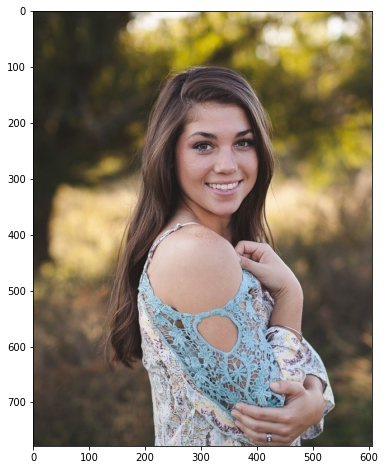

In [ ]:

image = cv2.imread('2.jpg')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



plt.imshow(image)


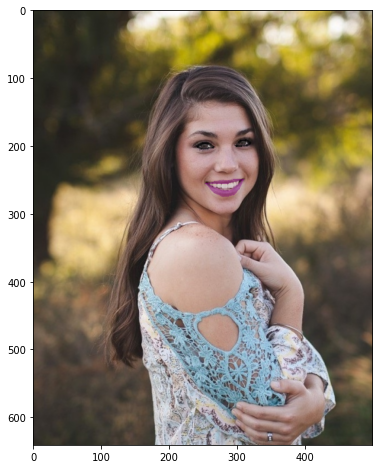

In [ ]:
image = imutils.resize(image, width=500)

# convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

"""
we use, Histogram of Oriented Gradients (HOG)
to detect the interest points/landmark points
on the face
"""
hog_face_detector = dlib.get_frontal_face_detector()

predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

"""
detect the face in grayscale image (works on normal image as well)
second parameter i.e. 1 is the number of image pyramid layers
to apply when upscaling the image prior to applying the detector
(this is equivalent to computing cv2.pyrup N number of times on
the image)
"""
faces = hog_face_detector(gray, 1)

# in case using CNN detector, use following line of code
# faces = cnn_face_detector(gray, 1)

"""
obtain the facial landmarks for the face in image,
then convert their coordinates to a numpy array
"""
shape = predictor(gray, faces[0])
shape = face_utils.shape_to_np(shape)
pil_image = Image.fromarray(image)

"""
create an ImageDraw object to draw on the image
RGBA allows us to control the transparency of
the colour
"""
d = ImageDraw.Draw(pil_image, 'RGBA')

"""
convert the numpy array containing facial landmark coordinates
in the form of tuples to a list of lists. eg:
array([(0, 1),    ->    [[0, 1],
       (2, 3)])          [2, 3]]
Reason: ImageDraw object (d), does not accept numpy array
while drawing shapes on the image
"""
shape = shape.tolist()
for i,j in enumerate(shape):
    shape[i] = (j[0], j[1])

# store indices of landmark points[0-67] to be used
indices = [48,49,50,51,52,53,54,64,63,62,61,60,48]
top_lip = [shape[i] for i in indices]
indices = [48,60,67,66,65,64,54,55,56,57,58,59,48]
bottom_lip = [shape[i] for i in indices]
indices = [36,37,38,39,40,41,36]
left_eye = [shape[i] for i in indices]
indices = [42,43,44,45,46,47,42]
right_eye = [shape[i] for i in indices]

# Draw the makeup on image
d.polygon(top_lip, fill=(128,0,128,100))
d.polygon(bottom_lip, fill=(128,0,128,100))
d.line(left_eye, fill=(0, 0, 0, 150), width=3)
d.line(right_eye, fill=(0, 0, 0, 150), width=3)


plt.imshow(pil_image)


In [ ]:
Rg, Gg, Bg = (223., 91., 111.)
pil_image = np.asarray(pil_image)
height, width = pil_image.shape[:2]
intensity = 0.5
imOrg = pil_image.copy()

"""
Get the boundary points of the blush on cheek
"""
def get_boundary_points(x, y):
    # interpolate i.e. obtain all the points between given vertice of polygon
    tck, u = interpolate.splprep([x, y], s=0, per=1)
    unew = np.linspace(u.min(), u.max(), 1000)
    xnew, ynew = interpolate.splev(unew, tck, der=0)
    tup = c_[xnew.astype(int), ynew.astype(int)].tolist()
    coord = list(set(tuple(map(tuple, tup))))
    coord = np.array([list(elem) for elem in coord])
    return np.array(coord[:, 0], dtype=np.int32), np.array(coord[:, 1], dtype=np.int32)

"""
Get all the points within selected polygon of blush
"""
def get_interior_points(x, y):
    intx = []
    inty = []

    """
    interior function to extend the list with points within 
    given range i.e. a to b
    """
    def ext(a, b, i):
        a, b = round(a), round(b)
        intx.extend(arange(a, b, 1).tolist())
        inty.extend((ones(b - a) * i).tolist())

    x, y = np.array(x), np.array(y)
    xmin, xmax = amin(x), amax(x)
    xrang = np.arange(xmin, xmax + 1, 1)
    for i in xrang:
        ylist = y[where(x == i)]
        ext(amin(ylist), amax(ylist), i)
    return np.array(intx, dtype=np.int32), np.array(inty, dtype=np.int32)

"""
Apply blush color on the face
"""
def apply_blush_color(r=Rg, g=Gg, b=Bg):
    global pil_image
    
    # normalize and change the intensities of pixels in 'LAB' color scheme
    val = color.rgb2lab((pil_image / 255.)).reshape(width * height, 3)
    L, A, B = mean(val[:, 0]), mean(val[:, 1]), mean(val[:, 2])
    L1, A1, B1 = color.rgb2lab(np.array((r / 255., g / 255., b / 255.)).reshape(1, 1, 3)).reshape(3, )
    ll, aa, bb = (L1 - L) * intensity, (A1 - A) * intensity, (B1 - B) * intensity
    val[:, 0] = np.clip(val[:, 0] + ll, 0, 100)
    val[:, 1] = np.clip(val[:, 1] + aa, -127, 128)
    val[:, 2] = np.clip(val[:, 2] + bb, -127, 128)
    
    # change the image array back to 'RGB' scheme
    pil_image = color.lab2rgb(val.reshape(height, width, 3)) * 255
    
"""
Smoothen the blush on cheek
"""
def smoothen_blush(x, y):
    global imOrg
    imgBase = zeros((height, width))
    
    """
    Fill the shape of blush with color
    c_() from pylab just zips two arrays index wise
    """
    cv2.fillConvexPoly(imgBase, np.array(c_[x, y], dtype='int32'), 1)
    # Blur the colour using GaussianBlur function
    imgMask = cv2.GaussianBlur(imgBase, (51, 51), 0)
    imgBlur3D = np.ndarray([height, width, 3], dtype='float')
    imgBlur3D[:, :, 0] = imgMask
    imgBlur3D[:, :, 1] = imgMask
    imgBlur3D[:, :, 2] = imgMask
    
    # Transform the image by adding blurred patch on cheek
    imOrg = (imgBlur3D * pil_image + (1 - imgBlur3D) * imOrg).astype('uint8')
#     return imgBase, np.array(c_[x, y], dtype='int32')

/usr/local/lib/python3.6/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][7]=x[0][0]
  (i, m, i)))
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][7]=x[1][0]
  (i, m, i)))


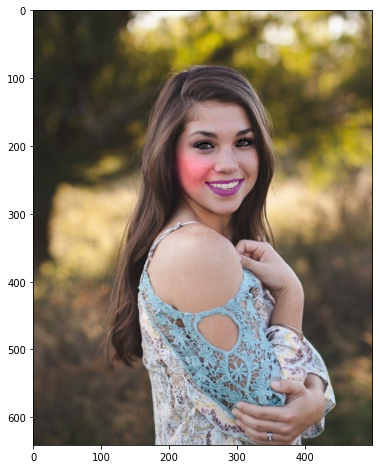

In [ ]:
# select indices of landmark points for blush on left cheek
indices = [1,2,3,4,48,31,36]
left_cheek_x = [shape[i][0] for i in indices]
left_cheek_y = [shape[i][1] for i in indices]

# Get the pixel points within polygon and apply color on those points
left_cheek_x, left_cheek_y = get_boundary_points(left_cheek_x, left_cheek_y)
left_cheek_y, left_cheek_x = get_interior_points(left_cheek_x, left_cheek_y)
apply_blush_color()
smoothen_blush(left_cheek_x, left_cheek_y)

plt.imshow(imOrg)
plt.show()

/usr/local/lib/python3.6/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][7]=x[0][0]
  (i, m, i)))
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][7]=x[1][0]
  (i, m, i)))


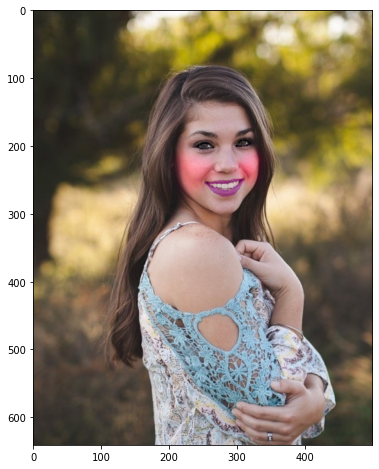

In [ ]:

# select indices of landmark points for blush on right cheek
indices = [15,14,13,12,54,35,45]
right_cheek_x = [shape[i][0] for i in indices]
right_cheek_y = [shape[i][1] for i in indices]

# Get the pixel points within polygon and apply color on those points
right_cheek_x, right_cheek_y = get_boundary_points(right_cheek_x, right_cheek_y)
right_cheek_y, right_cheek_x = get_interior_points(right_cheek_x, right_cheek_y)
apply_blush_color()
smoothen_blush(right_cheek_x, right_cheek_y)


plt.imshow(imOrg)
plt.show()

In [ ]:
import glob
import time
import keras

In [ ]:
def predict(image, height=224, width=224):
    im = image.copy()
    im = im / 255
    im = cv2.resize(im, (height, width))
    im = im.reshape((1,) + im.shape)
    
    pred = model.predict(im)
    mask = pred.copy()
    mask = mask.reshape((224, 224,1))
    row, col, _ = image.shape
    mask = cv2.resize(mask, (col, row))
    return mask

In [ ]:
# load hair detection model
# model source https://github.com/thangtran480/hair-segmentation/releases
model = keras.models.load_model('/content/gdrive/MyDrive/Virtual-Make-Up-master/hairnet_matting_30.hdf5')

In [ ]:
img = imOrg.copy()

# Predict the mask from the image
hairmask = predict(img)

(641, 500)


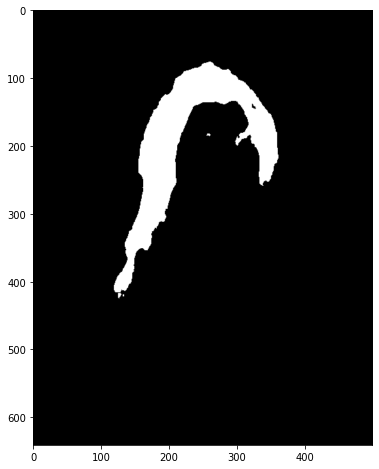

In [ ]:
# Mask Creation
threshold = 0.7
bit8_hairmask = hairmask.copy()

# Convert the float hairmask into uint8 values
bit8_hairmask[bit8_hairmask > threshold] = 255
bit8_hairmask[bit8_hairmask <= threshold] = 0

# convert unint8 mask to a boolean mask
bin_hairmask = bit8_hairmask.astype(np.bool)
print(bin_hairmask.shape)
plt.imshow(bin_hairmask)

In [ ]:
# Convert the 8bit mask into a 3 dimensional image with a hue swap
rgb_mask = bit8_hairmask.copy()

# add new dimension
rgb_mask = rgb_mask.astype(np.uint8)
rgb_mask = rgb_mask[:,:,np.newaxis]
print(rgb_mask.shape)

# repeat the dimension in the 3rd axis
rgb_mask = rgb_mask.repeat(3, axis = 2)

print(rgb_mask.shape)

(641, 500, 1)
(641, 500, 3)


In [ ]:
# break the color into its numerical components
color = (0,0,255)
r, g, b = color

# Set the r g b channels to their set
rgb_mask[:,:,0][bin_hairmask] = r
rgb_mask[:,:,1][bin_hairmask] = g
rgb_mask[:,:,2][bin_hairmask] = b

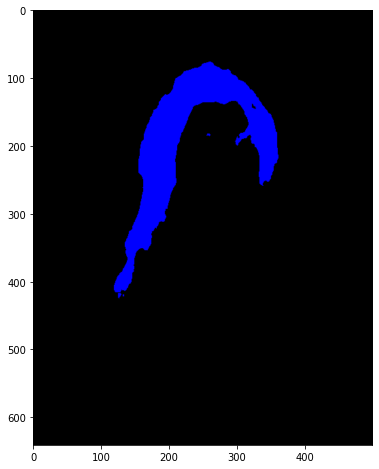

In [ ]:
plt.imshow(rgb_mask)

In [ ]:
# RGB to HLS Conversion
hls_mask = cv2.cvtColor(rgb_mask, cv2.COLOR_RGB2HLS)
hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
channel = 0

h_mask, h_img = hls_mask[:,:, channel], hls_img[:,:, channel]

h_img[bin_hairmask] = h_mask[bin_hairmask]

rgb_img = cv2.cvtColor(hls_img, cv2.COLOR_HLS2RGB)

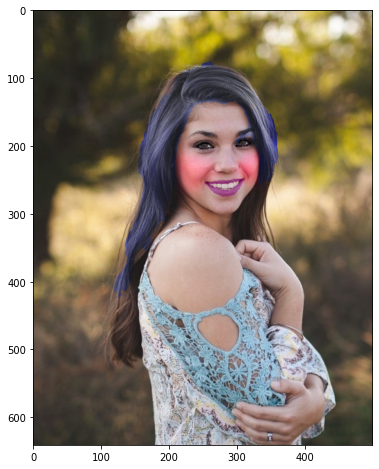

In [ ]:
plt.imshow(rgb_img)